In [1]:
# pip install PyPDF2
# pip install selenium
# pip install wordcloud

In [2]:
# Import libraries
import PyPDF2 as pydf
import re
import pandas as pd
import datetime as dt
import os
import shutil
import time
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys

In [3]:
# import graphing libraries
import wordcloud
from PIL import Image
import matplotlib.pyplot as plt
# % matplotlib inline

In [4]:
# Download location
download_folder = 'C:\\Users\\Dave\\Desktop\\Job Apps\\Legislative Assistant, Senator Marcus\\Bill Downloads'
image_save_base_url = 'C:\\Users\\Dave\\Desktop\\Job Apps\\Legislative Assistant, Senator Marcus\\Images'

In [5]:
# Align driver
DRIVER_PATH = '\\Users\\Dave\\Desktop\\Python\\chromedriver\\chromedriver.exe'
# Update Chrome settings to allow for pdf downloads
options = webdriver.ChromeOptions()
options.add_experimental_option('prefs', {
    'download.default_directory': download_folder, # Change default directory for downloads
    'download.prompt_for_download': False, # To auto download the file
    'download.directory_upgrade': True,
    'plugins.always_open_pdf_externally': True # It will not show PDF directly in chrome
})
driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)
# driver = webdriver.Chrome(executable_path=DRIVER_PATH)

## <font color='teal'>Retrieve PDFs</font>

In [6]:
# Url and info
ncleg_search = 'https://www.ncleg.gov/Search/BillText'
search_keys = 'Marcus'
session_keys = '2019-2020 Session'

In [7]:
# Designate words that won't be displayed in WordCloud exhibit
words_to_skip_list = ['a', 'the', 'an', 'of', 'be', 'to', 'when',
                      'where', 'which', 'session', 'and', 'then',
                      'day', 'per', 'that', 'for', 'after', 'this',
                      'days', 'may', 'they', 'other', 'once', 'not',
                      'from', 'under', 'been', 'have', 'there',
                      'sponsors', 'either', 'has', 'any', 'with']

In [8]:
# Xpaths of relevent elements
search_dropdown_xpath = '//*[@id="gsSearch"]'
search_input_xpath = '//*[@id="sSearchText"]'
session_dropdown_xpath = '//*[@id="sSession_chosen"]'
session_autocomplete_xpath = '//*[@id="sSession_chosen"]/div/div/input'
search_button_xpath = '//*[@id="billTextSearchForm"]/div/div[6]/button'

In [9]:
# Navigate to ncleg search site
driver.get(ncleg_search)

In [10]:
# Fill in Search options

# Open the Search dropdown (this dropdown should
# already be open, so no need to click
# # driver.find_element_by_xpath(search_dropdown_xpath).click()

# Send search info
driver.find_element_by_xpath(search_input_xpath).clear() # First clear search
driver.find_element_by_xpath(search_input_xpath).send_keys(search_keys) # Then send keywords

# Click to expand dropdown, filter to desired sesseion
driver.find_element_by_xpath(session_dropdown_xpath).click()
driver.find_element_by_xpath(session_autocomplete_xpath).send_keys(session_keys)

# Having filtered to sought option, select it
active_element = driver.switch_to_active_element()
active_element.send_keys(Keys.ENTER)

# Press the Search button
driver.find_element_by_xpath(search_button_xpath).click()

C:\Users\Dave\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: use driver.switch_to.active_element instead
  app.launch_new_instance()


In [11]:
def retrieveBills(download_folder, download_limit):
    
    # Clear downloads folder to make room for new retrievals
    for filename in os.listdir(download_folder):
        file_path = os.path.join(download_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    
    # Loop to retrieve players by href
    bills_list = []
    elements = driver.find_elements_by_xpath('//a[contains(@href, "/BillLookUp/")]')
    for element in elements:
        bills_list.append(element)
    num_bills = len(bills_list)
    print('Identified {} matching bills.'.format(num_bills))
    print('Downloading {} most recent bills.'.format(download_limit))
    
    # Establish dict to contain data for each bill
    bill_dict = {}
    
    if download_limit == None:
        upper_bound = num_bills  # Explicitly limit number of downloads
    else:
        upper_bound = download_limit # Implicitly allow all downloads
    
    for i in list(range(0, upper_bound)):
        
        # Need to rerun bills_list each time in order to refresh elements
        bills_list = []
        elements = driver.find_elements_by_xpath('//a[contains(@href, "/BillLookUp/")]')
        for element in elements:
            bills_list.append(element)
        
        # Navigate to bill specifics site
        bills_list[i].click()
        
        ### Retrieve bill information, then download
        
        # Retrieve bill number and name
        bill_number_xpath = '/html/body/div[1]/div/main/div[1]/div[3]'
        bill_number = driver.find_element_by_xpath(bill_number_xpath).text
        bill_name_xpath = '/html/body/div[1]/div/main/div[2]/div[1]/a'
        bill_name = driver.find_element_by_xpath(bill_name_xpath).text
        print('Beginning on {}: {}'.format(bill_number, bill_name))
        
        # Retrieve bill sponsors, clean and transform
        bill_sponsors_xpath = '/html/body/div[1]/div/main/div[3]/div[2]/div/div[4]'
        bill_sponsors = driver.find_element_by_xpath(bill_sponsors_xpath).text
        bill_sponsors_cleaned = bill_sponsors.replace('\n', ';').replace('(Primary)', '')
        bill_sponsors_individual = bill_sponsors_cleaned.split(';')
        bill_sponsors_individual_cleaned = []
        for ind in bill_sponsors_individual:
            bill_sponsors_individual_cleaned.append(ind.strip())

        # Check which sponsor(s) is primary
        bill_sponsors_dict = {}
        for sp in bill_sponsors_individual_cleaned:
            if bill_sponsors.find(sp) < bill_sponsors.find('Primary'):
                bill_sponsors_dict[sp] = {'Primary':True}
            else:
                bill_sponsors_dict[sp] = {'Primary':False}

        # Retrieve bill attributes
        bill_attributes_xpath = '/html/body/div[1]/div/main/div[3]/div[2]/div/div[6]'
        bill_attributes = driver.find_element_by_xpath(bill_attributes_xpath).text
        if bill_attributes.split(';')[0] == 'Public':
            bill_pub_loc = 'Public'
        elif bill_attributes.split(';')[0] == 'Local':
            bill_pub_loc = 'Local'
        else:
            bill_pub_loc = None

        # Retrieve bill keywords
        bill_keywords_xpath = '/html/body/div[1]/div/main/div[3]/div[2]/div/div[12]'
        bill_keywords = driver.find_element_by_xpath(bill_keywords_xpath).text

        # Store information about bill in dict
        bill_dict[bill_number] = {'Name':bill_name,
                                  'Sponsors':bill_sponsors_dict,
                                  'Breadth':bill_pub_loc,
                                  'Keywords':bill_keywords}
        
        # Click to download pdf
        driver.find_element_by_xpath(bill_name_xpath).click()
        
        # Navigate back to bills list page
        driver.back()
        print('Completed', bill_number)
        
    return bill_dict;


In [12]:
# Run retrieveBills, downloading pdfs and returning dict with metadata
bill_dict = retrieveBills(download_folder, download_limit=None) # set download_limit to None to ignore

Identified 36 matching bills.
Beginning on Senate Bill 861: Election Protection During COVID-19 Emergency.
Completed Senate Bill 861
Beginning on Senate Bill 797: Davidson/Demolition of Historic Structures.
Completed Senate Bill 797
Beginning on Senate Bill 772: Domestic Violence Victims Separation Waiver.
Completed Senate Bill 772
Beginning on Senate Bill 761 (=H1083): Huntersville Ocular Melanoma Study Funds.
Completed Senate Bill 761 (=H1083)
Beginning on Senate Bill 760: Funds to Study & Abate Ocular Melanoma.
Completed Senate Bill 760
Beginning on Senate Bill 744 (=S651): Polluter Pays.
Completed Senate Bill 744 (=S651)
Beginning on Senate Bill 732: Create Medicaid Access to Doula Services.
Completed Senate Bill 732
Beginning on Senate Bill 651 (=S744): Polluter Pays.
Completed Senate Bill 651 (=S744)
Beginning on Senate Bill 583 (=H769): Reduce Opp. Schol. Funds/Public Schools Funds.
Completed Senate Bill 583 (=H769)
Beginning on Senate Bill 486: North Carolina Equal Pay Act.
Com

In [13]:
# Walk os to retrieve files from Downloads folder
onlyfiles = [f for f in os.listdir(download_folder) if os.path.isfile(os.path.join(download_folder, f))]
full_paths_list = []
for f in onlyfiles:
    full_paths_list.append(download_folder + '\\' + f)

In [14]:
# # Explicitly set bill to investigate
# bill_num_in_list = 1
# bill_num_as_str = list(bill_dict.keys())[bill_num_in_list].split(' ')[-1]

# # Locate and set file
# target_file = []
# for file in onlyfiles:
#     if bill_num_as_str in file:
#         target_file.append(file)

# # Assure only one target file
# if len(target_file) > 1:
#     print('Error, too many matching files...')
# elif len(target_file) == 0:
#     print('Error, zero matching files')
# elif len(target_file) == 1:
#     print('Run function here...')

# # Build full path
# target_full_filepath = download_folder + '\\' + target_file[0]
# print(target_full_filepath)

## <font color='teal'>Extract from PDF</font>

In [15]:
# Function to extract text from pdf, page by page, and write to dict
def text_extractor(path, num_pages):
    pages_dict = {}
    with open(path, 'rb') as file:
        pdf = pydf.PdfFileReader(file)
        for i in list(range(0, num_pages)):
            page = pdf.getPage(i)
            pages_dict[i+1] = page.extractText()
    return pages_dict;

In [16]:
# Function to concatenate text from pages to single string
def page_compiler(pages_dict):
    pdf_text = ''
    for page in pages_dict.keys():
        pdf_text = pdf_text + pages_dict[page]
    return pdf_text;

In [17]:
# Function to retrieve pdfs and return text analysis data
# Relies upon text_extractor() and page_compiler()
def pdfExtractor(pdf_filepaths): # words_to_skip_list
    
    # Store each pdf with a key, text comprising pdfs as str
    pdfs_dict = {}
    full_text = ''
    for file in pdf_filepaths:
        
        # Store each bills pages, compiled text in tuple
        single_file_tuple = {}
    
        # Create pdf object and retrieve page count 
        pdf = pydf.PdfFileReader(open(file, 'rb'))
        num_pages = pdf.getNumPages()

        # Run intrafunctions to retrieve page-by-page text,
        # then compile to single string object
        pages_dict = text_extractor(file, num_pages)
        pdf_text = page_compiler(pages_dict)
        single_file_tuple = (pages_dict, pdf_text)
        file_tail = file.split('\\')[-1].replace('.pdf', '')
        pdfs_dict[file_tail] = single_file_tuple
        full_text = full_text + pdf_text
    
    return (pdfs_dict, full_text);

In [18]:
# Run pdfExtractor()
extraction_tuple = pdfExtractor(full_paths_list)
pdfs_dict = extraction_tuple[0]
full_text = extraction_tuple[1]

## <font color='teal'>Create Dictionary to Prevent non-Words in WordCloud</font><font color='red'><i> Not Deployed</font>

In [19]:
# # Check for presence of each bill's text in full_text
# for bill in bill_dict.keys():
#     print(bill)
#     print(bill in full_text)
#     print(bill_dict[bill]['Name'])
#     print(bill_dict[bill]['Name'] in full_text)
#     print('')

In [20]:
# # Use regex to retrieve words found in pdf
# all_words_identified = re.findall(r'\w+', full_text)

# # Dedupe to all unique words, sort ascending
# unique_words_identified = list(set(all_words_identified))
# unique_words_identified.sort(reverse=False)

# # Count instances of each unique word found in pdf
# word_counts_dict = {}
# for word in unique_words_identified:
#     if word not in words_to_skip_list:
#         count = full_text.count(word)
#         word_counts_dict[word] = count

# # Construct df with words having most frequency at top
# word_counts_df = pd.DataFrame.from_dict(word_counts_dict, orient='index', columns=['Count'])
# word_counts_df.sort_values('Count', ascending=False, inplace=True)

In [21]:
# word_counts_df[0:9]

In [22]:
# # Filter to only words with X+ chars
# char_filter = 5
# mask = (word_counts_df.index.str.len() >= char_filter)
# filtered_word_counts_df = word_counts_df.loc[mask]

In [23]:
# filtered_word_counts_df[0:9]

In [24]:
# # Online dictionary of valid words
# # https://svnweb.freebsd.org/csrg/share/dict/words?view=log
# svnweb_dictionary = 'C:\\Users\\Dave\\Desktop\\Job Apps\\Legislative Assistant, Senator Marcus\\svnweb_dictionary.txt'
# additions_dictionary = 'C:\\Users\\Dave\\Desktop\\Job Apps\\Legislative Assistant, Senator Marcus\\additions_dictionary.txt'

In [25]:
# # Read in both dictionaries as lists, make single lookup library

# # Official
# with open(svnweb_dictionary, "r") as f:
#     unclean_official_dictionary = f.readlines()
# official_dictionary = []
# for word in unclean_official_dictionary:
#     official_dictionary.append(word.replace('\n', ''))

# # Additions
# with open(additions_dictionary, "r") as f:
#     unclean_additions_dictionary = f.readlines()
# additions_dictionary = []
# for word in unclean_additions_dictionary:
#     additions_dictionary.append(word.replace('\n', ''))

# # Complete dictionary
# complete_dictionary = official_dictionary + additions_dictionary
# complete_dictionary = sorted(complete_dictionary)

In [26]:
# # Filter to only words found in complete dictionary
# recognized_word_counts_df = filtered_word_counts_df[filtered_word_counts_df.index.isin(complete_dictionary)]

## <font color='teal'>Construct and Save WordCloud Exhibit</font>

In [27]:
# WordCloud package
# https://www.datacamp.com/community/tutorials/wordcloud-python

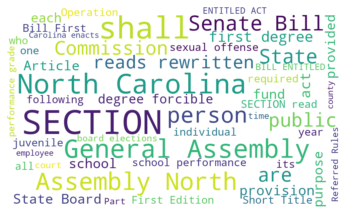

In [28]:
# Create and generate a word cloud image
wc_exhibit = wordcloud.WordCloud(stopwords=words_to_skip_list, 
                                 max_font_size=100, min_font_size=10,
                                 max_words=50, min_word_length=3,
                                 width=1000, height=600,
                                 background_color="white").generate(full_text)

# Display the generated image:
plt.imshow(wc_exhibit, interpolation='bilinear')
# plt.title('All Bills Sponsored by Senator Marcus in the 2019-2020 Session')
plt.axis("off")
plt.show()

In [29]:
# Save the image in the img folder:
now_str = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
wc_exhibit.to_file('{}\\wc_exhibit_{}.png'.format(image_save_base_url, now_str));

## <font color='teal'>Bill Metadata</font>

In [30]:
# Retrieve keywords bills, store in single list as sep elems
keywords_across_bills = []
for bill in bill_dict.keys():
    keywords_single_bill_list = bill_dict[bill]['Keywords'].split(',')
    cleaned_keywords_single_bill_list = []
    for keyword in keywords_single_bill_list:
        cleaned_keywords_single_bill_list.append(keyword.strip())
    keywords_across_bills = keywords_across_bills + cleaned_keywords_single_bill_list
keywords_across_bills = list(set(keywords_across_bills))
keywords_across_bills.sort(reverse=False)

# Identify overlap of keywords on bills
keyword_counts_dict = {}
for keyword in keywords_across_bills:
    keyword_count = 0
    for bill in bill_dict.keys():
        keywords_single_bill_list = bill_dict[bill]['Keywords'].split(',')
        cleaned_keywords_single_bill_list = []
        for k in keywords_single_bill_list:
            cleaned_keywords_single_bill_list.append(k.strip())
        if keyword in cleaned_keywords_single_bill_list:
            keyword_count += 1
    keyword_counts_dict[keyword] = keyword_count

# Create DataFrame, sorted with most frequent keywords occuring first
keyword_counts_df = pd.DataFrame.from_dict(keyword_counts_dict, orient='index', columns=['Count'])
keyword_counts_df.sort_values('Count', inplace=True, ascending=False)

In [31]:
# keyword_counts_df.head(10)

In [32]:
# Retrieve sponsors store in single list as sep elems
all_sponsors = []
for bill in bill_dict.keys():
    all_sponsors = all_sponsors + list(bill_dict[bill]['Sponsors'].keys())
all_sponsors = list(set(all_sponsors))
all_sponsors.sort(reverse=False)

# Identify overlap of sponsors on bills
sponsor_counts_dict = {}
for sponsor in all_sponsors:
    sponsor_count = 0
    for bill in bill_dict.keys():
        if sponsor in list(bill_dict[bill]['Sponsors'].keys()):
            sponsor_count += 1
    sponsor_counts_dict[sponsor] = sponsor_count

# Create DataFrame, sorted with most frequent sponsors occuring first
sponsor_counts_df = pd.DataFrame.from_dict(sponsor_counts_dict, orient='index', columns=['Count'])
sponsor_counts_df.sort_values('Count', inplace=True, ascending=False)

In [33]:
# sponsor_counts_df.head(10)

## <font color='teal'>Bill Metadata Graphing</font>

In [34]:
# Font formats for title, text
title_font_dict = {'family': 'arial',
                   'color': 'black',
                   'weight': 'normal',
                   'size': 20}
text_font_dict = {'family': 'arial',
                  'color': 'black',
                  'weight': 'normal',
                  'size': 16}

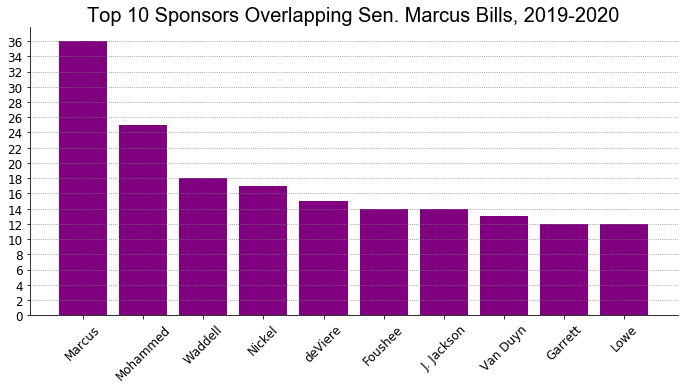

In [37]:
# Create figure1
fig1 = plt.figure(1)

# Create subplot1, sponsor frequencies in a bar chart
plt.subplot(111) # the three-digit int controls positioning of subplot in fig
ax1 = fig1.add_axes([0, 0, 1.5, 1]) # Graph dimensions
ax1.bar(x = sponsor_counts_df.index[0:10],
        height = sponsor_counts_df['Count'].iloc[0:10],
        color = 'purple') # Assign data to x, y

# Format exhibit
plt.title('Top 10 Sponsors Overlapping Sen. Marcus Bills, 2019-2020',
          fontdict = title_font_dict) # Set title and title format
plt.xlabel('', fontdict = text_font_dict) # Set font of x-axis label
ax1.axes.yaxis.set_visible(True) # Show y-axis tick labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(linestyle=':', axis='y',  color='gray') # linewidth='0.5',
plt.yticks(list(range(0, max(sponsor_counts_df['Count'].iloc[0:10])+2, 2)))

# # Add data labels at top of bars
# x_ints = list(range(0, len(sponsor_counts_df)))
# for x,y in zip(x_ints, sponsor_counts_df['Count']):
#     label = "{:.0f}".format(y) # Set decimal precision to 0
#     plt.annotate(label, # This is the text
#                  (x, y), # This is the point to label
#                  textcoords = "offset points", # How to position the text
#                  xytext=(0,5), # Distance from text to points (x,y)
#                  ha = 'center') # 'left', 'right' or 'center'

# Save the image in the img folder:
now_str = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
plt.savefig('{}\\sponsors_exhibit_{}.png'.format(image_save_base_url, now_str));

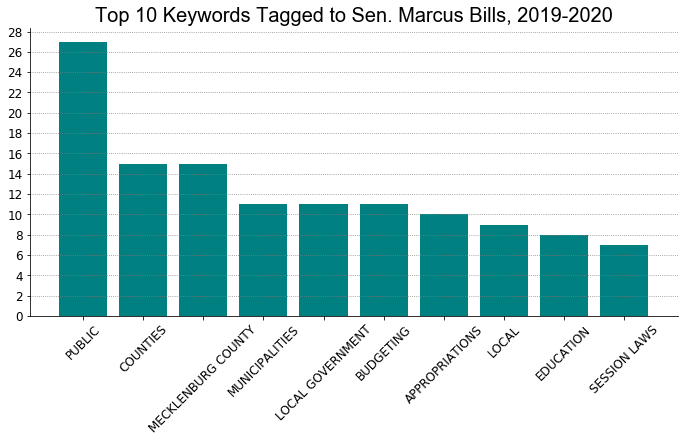

In [38]:
# Create figure2
fig2 = plt.figure(2)

# Create subplot2, keyword frequencies in a bar chart
plt.subplot(111) # the three-digit int controls positioning of subplot in fig
ax2 = fig2.add_axes([0, 0, 1.5, 1]) # Graph dimensions
ax2.bar(x = keyword_counts_df[0:10].index,
        height = keyword_counts_df['Count'].iloc[0:10],
        color = 'teal')

# Format exhibit
plt.title('Top 10 Keywords Tagged to Sen. Marcus Bills, 2019-2020',
          fontdict = title_font_dict) # Set title and title format
plt.xlabel('', fontdict = text_font_dict) # Set font of x-axis label
ax2.axes.yaxis.set_visible(True) # Show y-axis tick labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(linestyle=':', axis='y',  color='gray') # linewidth='0.5',
plt.yticks(list(range(0, max(keyword_counts_df['Count'].iloc[0:10])+2, 2)))

# # Add data labels at top of bars
# x_ints = list(range(0, len(keyword_counts_df)))
# for x,y in zip(x_ints, keyword_counts_df['Count']):
#     label = "{:.0f}".format(y) # Set decimal precision to 0
#     plt.annotate(label, # This is the text
#                  (x, y), # This is the point to label
#                  textcoords = "offset points", # How to position the text
#                  xytext=(0,5), # Distance from text to points (x,y)
#                  ha = 'center') # 'left', 'right' or 'center'

# Save the image in the img folder:

now_str = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
plt.savefig('{}\\keywords_exhibit_{}.png'.format(image_save_base_url, now_str));